In [ ]:
    ! pip install -q kaggle
from google.colab import files

# files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import numpy.random as random
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.svm import SVC, OneClassSVM
from sklearn.multiclass import OneVsRestClassifier
from skimage.feature import local_binary_pattern

import torch
import torch.nn as nn
import torch,torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import *
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, RandomResizedCrop, ColorJitter, ToPILImage, ToTensor
import torch.nn.functional as F
import torchvision.utils
from torch.autograd import Variable
from torch import optim


import matplotlib.image as image
import matplotlib.pyplot as plt

# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/CS679_project"
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/CS_679_Project"
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/CS679_Project_nrj"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Download data, set working directory

In [ ]:
# make working directory to the project folder
# %cd /content/drive/MyDrive/CS_679_Project/   
%cd /content/drive/MyDrive/CS679_Project_nrj/

/content/drive/MyDrive/CS679_Project_nrj


In [ ]:
%ls

best_model.pt  kaggle.json  model/  test/  test_5/  train/  train_5/


In [ ]:
#download dataset
# !kaggle datasets download -d miljan/stanford-dogs-dataset-traintest --unzip

100% 392M/393M [00:18<00:00, 22.9MB/s]
100% 393M/393M [00:18<00:00, 21.9MB/s]


## Create torch dataset

It will read two images and return them, as well as their label. If they are in the same category, the same dog breed, it will return 0, and otherwise, it will return 1.

In [ ]:
# Define LBP
def lbp(image, num_points=8, radius=1):
    lbp_image = local_binary_pattern(image, num_points, radius, method='uniform')
    hist, _ = np.histogram(lbp_image, bins=np.arange(num_points + 3), range=(0, num_points + 2), density=True)
    return hist

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        n = len(self.imageFolderDataset)
        #print(n)
        img0_tuple = self.imageFolderDataset[np.random.choice(n)]

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.choice([False, True])
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = self.imageFolderDataset[np.random.choice(n)]
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = self.imageFolderDataset[np.random.choice(n)] 
                if img0_tuple[1] != img1_tuple[1]:
                    break
        
        img0 = img0_tuple[0]
        img1 = img1_tuple[0]

        # conversion tyep: RGB / L.    (L is single channel)
        conv_type = 'RGB'
        img0 = img0.convert(conv_type)
        img1 = img1.convert(conv_type)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/subset5_all/train")

# Resize the images and transform to tensors
# can change the size here
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

NameError: ignored

In [ ]:
siamese_dataset.__getitem__(0)[0].size()

torch.Size([3, 100, 100])

### Visualization

In [ ]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

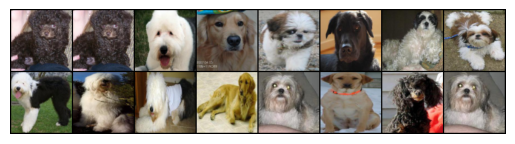

[1. 1. 0. 0. 0. 0. 1. 0.]


In [ ]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same dog breed, label is 0, same dog breed in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

## The Siamese Neural Network

In [ ]:
t = torch.randn((1,3,224,224))
cnn1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=4),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=3),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=4, stride=1),
            nn.ReLU(inplace=True),
        )

t = cnn1(t)
t.size()

torch.Size([1, 64, 5, 5])

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True)
        )


        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
# nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(kernel_size=2),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=4),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=3),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(in_channels=128, out_channels=64, kernel_size=4, stride=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#         )
X = torch.randn(3, 224, 224)
cnn1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10)
X = cnn1(X)
print(X.size())
mp1 =nn.MaxPool2d(kernel_size=2)
X = mp1(X)
print(X.size())
cnn2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=4)
X = cnn2(X)
print(X.size())

cnn3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=3)
X = cnn3(X)
print(X.size())
cnn4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=4, stride=1)
X = cnn4(X)
print(X.size())




torch.Size([64, 215, 215])
torch.Size([64, 107, 107])
torch.Size([128, 26, 26])
torch.Size([128, 8, 8])
torch.Size([64, 5, 5])


In [ ]:
#create the Siamese Neural Network
class SiameseNetwork2(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=4),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=4, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )


        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
# class SiameseNetwork2(nn.Module):

#     def __init__(self):
#         super(SiameseNetwork2, self).__init__()

#         # Setting up the Sequential of CNN Layers
#         self.cnn1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10),
#             nn.MaxPool2d(kernel_size=2),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=4),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=3),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(in_channels=128, out_channels=64, kernel_size=4, stride=1),
#             nn.ReLU(inplace=True),
#         )

#         self.fc1 = nn.Linear(64*5*5, 4096)

#         self.fc2 = nn.Sequential(
#             nn.Linear(4096, 1024),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(1024, 256),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(256,1)
#         )
        
#     def forward_once(self, x):
#         # This function will be called for both images
#         # Its output is used to determine the similiarity
#         output = self.cnn1(x)
#         output = output.view(output.size()[0], -1)
#         output = self.fc1(output)
#         return output

#     def forward(self, input1, input2):
#         # In this function we pass in both images and obtain both vectors
#         # which are returned
#         output1 = self.forward_once(input1)
#         output1 = F.sigmoid(output1)
#         output2 = self.forward_once(input2)
#         output2 = F.sigmoid(output2)
        
#         # calculate disimilarity
#         Y = torch.abs(output1 - output2)

#         # path through FC
#         disimilarity = self.fc2(Y)

#         # final prediction
#         pred = F.sigmoid(disimilarity)

#         return pred, disimilarity

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

## Training SNN

In [ ]:
# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

## OPTION 1: SNN with contrastive loss; input is channel*100*100
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss() 

## OPTION 2: SNN with BCE ; input is 3*224*224
# net = SiameseNetwork2().to(device)
# criterion = nn.BCELoss()


optimizer = optim.Adam(net.parameters(), lr = 0.001)

NameError: ignored

In [ ]:
def train_snn1(snn, train_dataloader, optimizer, criterion):
    counter = []
    loss_history = [] 
    iteration_number= 0

    # Iterate throught the epochs
    for epoch in range(250):

        # Iterate over batches
        for i, (img0, img1, label) in enumerate(train_dataloader, 0):

            # Send the images and labels to CUDA
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = net(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = criterion(output1, output2, label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()

            # Every 10 batches print out the loss
            if i % 10 == 0 :
                print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    show_plot(counter, loss_history)


def train_snn2(snn, train_dataloader, optimizer, criterion):
    counter = []
    loss_history = [] 
    iteration_number= 0
    # Iterate throught the epochs
    
    for epoch in range(250):

        # Iterate over batches
        for i, (img0, img1, label) in enumerate(train_dataloader, 0):

            # Send the images and labels to CUDA
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            pred, d = snn(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            bce = criterion(pred, label)

            # Calculate the backpropagation
            bce.backward()

            # Optimize
            optimizer.step()

            # Every 10 batches print out the loss
            if i % 10 == 0 :
                print(f"Epoch number {epoch}\n Current loss {bce.item()}\n")
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(bce.item())

    show_plot(counter, loss_history)

train_snn1(snn=net, train_dataloader=train_dataloader, optimizer=optimizer, criterion=criterion)

In [ ]:
## save model
PATH = "./model/snn1_subset5_BN.pt"
torch.save(net, PATH)

In [ ]:
import torchvision.models as models
import torch.nn as nn

# use pretrained resnet18
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Load the pretrained ResNet-18 model
        self.resnet18 = models.resnet18(pretrained=True)

        # Remove the last fully connected layer to get the feature vector
        self.resnet18 = nn.Sequential(*list(self.resnet18.children())[:-1])

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(512, 1024)
            # nn.ReLU(inplace=True),
            # nn.Dropout(0.5),

            # nn.Linear(1024, 256),
            # nn.ReLU(inplace=True),
            # nn.Dropout(0.5),

            # nn.Linear(256, 8)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similarity
        output = self.resnet18(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function, we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2


## SVM Classifier

In [ ]:
PATH = "./model/snn_subset5_BN_resize_pretrained_continue_trained_0.00003.pt"
# net = SiameseNetwork()
snn = torch.load(PATH).to(device)

snn.eval()

SiameseNetwork(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
class SVMDataset_snn1(Dataset):
    def __init__(self, snn, imageFolderDataset, prototype_path, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.prototype_path = prototype_path
        self.prototype_imgs = sorted(os.listdir(self.prototype_path))
        self.transform = transform
        self.snn = snn
        
    
    def _processImg(self, path):
        dog = Image.open(path)
        conv_type = "RGB"
        dog = dog.convert(conv_type)
        if self.transform is not None:
            dog = self.transform(dog)
        dog = dog.to(device)
        return dog.unsqueeze(0)
    
    
    def __getitem__(self,index):
        path1, breed1 = self.imageFolderDataset.imgs[index]
        dog1 = self._processImg(path1)

        p = len(self.prototype_imgs)
        d = np.zeros(p)

        for i in range(p):
            prototype_img = self.prototype_imgs[i]
            path2 = self.prototype_path + prototype_img
            dog_p = self._processImg(path2)
            output1, output2 = self.snn(dog1, dog_p)
            dis = F.pairwise_distance(output1, output2)
            d[i] = dis

        return d, breed1

    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)


class SVMDataset_snn2(Dataset):
    def __init__(self, snn, imageFolderDataset, imageFolderDataset_proto, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.imageFolderDataset_proto = imageFolderDataset_proto
        self.transform = transform
        
    
    def _processImg(self, path):
        dog = Image.open(path)
        conv_type = "RGB"
        dog = dog.convert(conv_type)
        if self.transform is not None:
            dog = self.transform(dog)
        dog = dog.to(device)
        return dog.unsqueeze(0)
    
    
    def __getitem__(self,index):
        path1, breed1 = self.imageFolderDataset.imgs[index]
        dog1 = self._processImg(path1)

        p = len(self.imageFolderDataset_proto.imgs)
        d = np.zeros(p)

        for i in range(p):
            path2, breed2 = self.imageFolderDataset_proto.imgs[i]
            dog_p = self._processImg(path2)
            p, disimilarity = snn(dog1, dog_p)
            d[i] = disimilarity

        return d, breed1

    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

### Get Dismilarity Matrix

For a single picture, we want to get its dimilarity with all the prototypes.

Then, if there are $n$ images in the training set and $p$ prototype pictures, then the overall input size to one-vs-rest svm is $n \times p$

In [ ]:
prototype_path = "./prototypes/"
# folder_dataset_prototype = datasets.ImageFolder(root="./data/subset/prototype_example/")

folder_dataset_train = datasets.ImageFolder(root="./train_5/")
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

svm_dataset_train = SVMDataset_snn1(snn, imageFolderDataset = folder_dataset_train, 
                             prototype_path = prototype_path, 
                             transform=transformation)

# svm_dataloader = DataLoader(svm_dataset, num_workers=1, batch_size=1, shuffle=True)

In [ ]:
X = np.zeros((len(svm_dataset_train), len(os.listdir(prototype_path))))
y = np.zeros(len(svm_dataset_train))
for i in range(X.shape[0]):
    d, breed = svm_dataset_train.__getitem__(i)
    X[i] = d
    y[i] = breed

# shuffle
train_data = np.c_[X, y]
np.random.shuffle(train_data)

X = train_data[:,:-1]
y = train_data[:,-1]

### Training SVM

In [ ]:
# define model
model = SVC(C=1, kernel='poly', gamma = 'auto')
# define the ovr strategy
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X, y)
# make predictions
yhat = ovr.predict(X)

In [ ]:
sum(yhat==y)/len(y)

0.784

### 

<Axes: ylabel='Density'>

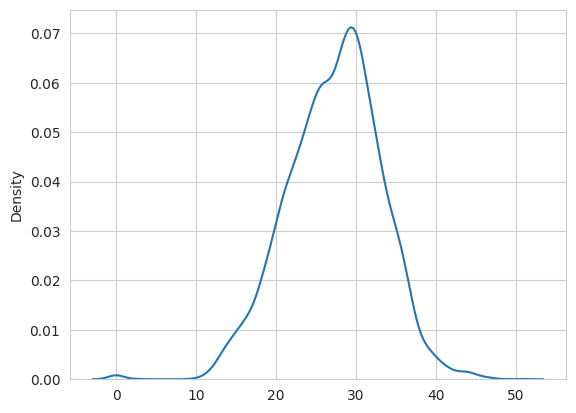

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
#sns.histplot(X.reshape(-1))
sns.kdeplot(X.reshape(-1))

### Testing


In [ ]:
PATH = "./model/snn_subset5_BN_resize_pretrained_continue_trained.pt"
# net = SiameseNetwork()
snn = torch.load(PATH).to(device)

snn.eval()

SiameseNetwork(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
folder_dataset_test = datasets.ImageFolder(root="./test_5/")
svm_dataset_test = SVMDataset_snn1(snn, imageFolderDataset = folder_dataset_test, 
                             prototype_path = prototype_path,  
                             transform=transformation)

In [ ]:
X_test = np.zeros((len(svm_dataset_test), len(os.listdir(prototype_path))))
y_test = np.zeros(len(svm_dataset_test))
for i in range(X_test.shape[0]):
    d, breed = svm_dataset_test.__getitem__(i)
    X_test[i] = d
    y_test[i] = breed

test_data = np.c_[X_test, y_test]
np.random.shuffle(test_data)

X_test = test_data[:,:-1]
y_test = test_data[:,-1]

In [ ]:
yhat_test = ovr.predict(X_test)
sum(yhat_test == y_test)/len(y_test)

0.4778761061946903

## Classify method: threshold and mode

In [ ]:
class TestDataset_threshold(Dataset):
    def __init__(self, snn, imageFolderDataset_train, imageFolderDataset_test, threshold = 1, transform=None):
        self.imageFolderDataset_train = imageFolderDataset_train
        self.imageFolderDataset_test = imageFolderDataset_test
        self.transform = transform
        self.threshold = threshold
        
    
    def _processImg(self, path):
        dog = Image.open(path)
        conv_type = "RGB"
        dog = dog.convert(conv_type)
        if self.transform is not None:
            dog = self.transform(dog)
        dog = dog.to(device)
        return dog.unsqueeze(0)
    
    
    def __getitem__(self,index):
        path1, breed1 = self.imageFolderDataset_test.imgs[index]
        dog1 = self._processImg(path1)

        p = len(self.imageFolderDataset_train.imgs)
        d = np.zeros(5)

        for i in range(p):
            dog2, breed2 = self.imageFolderDataset_train.imgs[i]
            dog_train = self._processImg(dog2)
            output1, output2 = snn(dog1, dog_train)
            dis = F.pairwise_distance(output1, output2)
            if dis < self.threshold:
                d[breed2] += 1

        return d, breed1

    
    def __len__(self):
        return len(self.imageFolderDataset_test.imgs)

In [ ]:
folder_dataset_test = datasets.ImageFolder(root="./data/subset5_all/test/")
folder_dataset_train = datasets.ImageFolder(root="./data/subset5_all/train/")

transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

threshold_test_dataset = TestDataset_threshold(snn, 
                                               imageFolderDataset_train = folder_dataset_train, 
                                               imageFolderDataset_test = folder_dataset_test,
                                               threshold = 2,
                                                transform=transformation)

In [ ]:
y_test_pred = np.zeros(len(folder_dataset_test))
y_test_true = np.zeros(len(folder_dataset_test))
for i in range(len(threshold_test_dataset)):
    d, breed = threshold_test_dataset.__getitem__(i)
    y_test_pred[i] = np.argmax(d)
    y_test_true[i] = breed


In [ ]:
sum(y_test_pred == y_test_true)/len(y_test_pred)

0.4

In [ ]:
d

array([ 0.,  0., 14.,  0., 99.])

In [ ]:
y_test_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

## Have we seen this type of dog?

In [ ]:
PATH = "./model/snn1_subset5_BN.pt"
# net = SiameseNetwork()
snn = torch.load(PATH).to(device)

snn.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bia

In [ ]:
class SeenDataset(Dataset):
    def __init__(self, snn, seenFolderDataset, prototype_path, transform=None):
        self.imageFolderDataset = seenFolderDataset
        self.prototype_path = prototype_path
        self.prototype_imgs = sorted(os.listdir(self.prototype_path))
        self.transform = transform
        self.snn = snn
        
    
    def _processImg(self, path):
        dog = Image.open(path)
        conv_type = "RGB"
        dog = dog.convert(conv_type)
        if self.transform is not None:
            dog = self.transform(dog)
        dog = dog.to(device)
        return dog.unsqueeze(0)
    
    
    def __getitem__(self,index):
        path1, breed1 = self.imageFolderDataset.imgs[index]
        dog1 = self._processImg(path1)

        p = len(self.prototype_imgs)
        d = np.zeros(p)

        for i in range(p):
            prototype_img = self.prototype_imgs[i]
            path2 = self.prototype_path + prototype_img
            dog_p = self._processImg(path2)
            output1, output2 = self.snn(dog1, dog_p)
            dis = F.pairwise_distance(output1, output2)
            d[i] = dis

        return d, 1

    def __len__(self):
        return len(self.imageFolderDataset.imgs)


class UnseenDataset(Dataset):
    def __init__(self, snn, unseenFolderDataset, prototype_path, transform=None):
        self.imageFolderDataset = unseenFolderDataset
        self.prototype_path = prototype_path
        self.prototype_imgs = sorted(os.listdir(self.prototype_path))
        self.transform = transform
        self.snn = snn
        
    
    def _processImg(self, path):
        dog = Image.open(path)
        conv_type = "RGB"
        dog = dog.convert(conv_type)
        if self.transform is not None:
            dog = self.transform(dog)
        dog = dog.to(device)
        return dog.unsqueeze(0)
    
    
    def __getitem__(self,index):
        path1, breed1 = self.imageFolderDataset.imgs[index]
        dog1 = self._processImg(path1)

        p = len(self.prototype_imgs)
        d = np.zeros(p)

        for i in range(p):
            prototype_img = self.prototype_imgs[i]
            path2 = self.prototype_path + prototype_img
            dog_p = self._processImg(path2)
            output1, output2 = self.snn(dog1, dog_p)
            dis = F.pairwise_distance(output1, output2)
            d[i] = dis

        return d, -1

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
prototype_path = "./data/subset5_all/prototypes/"

folder_dataset_seen_train = datasets.ImageFolder(root="./data/subset5_all/train/")
# folder_dataset_unseen_train = datasets.ImageFolder(root="./data/subset5_all/train_unseen/")
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

seen_dataset_train = SeenDataset(snn, seenFolderDataset = folder_dataset_seen_train, 
                             prototype_path = prototype_path, 
                             transform=transformation)

# unseen_dataset_train = UnseenDataset(snn, unseenFolderDataset = folder_dataset_unseen_train, 
#                              prototype_path = prototype_path, 
#                              transform=transformation)

In [ ]:
X1 = np.zeros((len(seen_dataset_train), len(os.listdir(prototype_path))))
y1 = np.zeros(len(seen_dataset_train))
# X2 = np.zeros((len(unseen_dataset_train), len(os.listdir(prototype_path))))
# y2 = np.zeros(len(unseen_dataset_train))

for i in range(X1.shape[0]):
    d, label = seen_dataset_train[i]
    X1[i] = d
    y1[i] = label

# for i in range(X2.shape[0]):
#     d, label = unseen_dataset_train[i]
#     X2[i] = d
#     y2[i] = label

# # shuffle
# train_data = np.c_[np.r_[X1, X2], np.r_[y1, y2]]
# np.random.shuffle(train_data)

# X = train_data[:,:-1]
# y = train_data[:,-1]

In [ ]:
import pickle

# define model
# svm = SVC(C=1, kernel='poly', gamma = 'auto')
ocsvm = OneClassSVM(kernel='poly', gamma = 'auto')
# fit model
# svm.fit(X, y)
ocsvm.fit(X)

filename = "OCSVM_seen.pickle"

# save model
pickle.dump(ocsvm, open(filename, "wb"))

# load model
# loaded_model = pickle.load(open(filename, "rb"))

In [ ]:
# make predictions
yhat = svm.predict(X)

sum(yhat==y)/len(y)

0.8581005586592179

### test

In [ ]:
folder_dataset_seen_test = datasets.ImageFolder(root="./data/subset5_all/test/")
folder_dataset_unseen_test = datasets.ImageFolder(root="./data/subset5_all/test_unseen/")
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

seen_dataset_test = SeenDataset(snn, seenFolderDataset = folder_dataset_seen_test, 
                             prototype_path = prototype_path, 
                             transform=transformation)

unseen_dataset_test = UnseenDataset(snn, unseenFolderDataset = folder_dataset_unseen_test, 
                             prototype_path = prototype_path, 
                             transform=transformation)

In [ ]:
X1_test = np.zeros((len(seen_dataset_test), len(os.listdir(prototype_path))))
y1_test = np.zeros(len(seen_dataset_test))
X2_test = np.zeros((len(unseen_dataset_test), len(os.listdir(prototype_path))))
y2_test = np.zeros(len(unseen_dataset_test))

for i in range(X1_test.shape[0]):
    d, label = seen_dataset_test[i]
    X1_test[i] = d
    y1_test[i] = label

for i in range(X2_test.shape[0]):
    d, label = unseen_dataset_test[i]
    X2_test[i] = d
    y2_test[i] = label

# shuffle
test_data = np.c_[np.r_[X1_test, X2_test], np.r_[y1_test, y2_test]]
np.random.shuffle(test_data)

X_test = test_data[:,:-1]
y_test = test_data[:,-1]
# make predictions
# yhat_test = svm.predict(X_test)
y_test[y_test == 0] = -1

In [ ]:

yhat_test = ocsvm.predict(X1_test)

sum(yhat_test==y1_test)/len(y1_test)

0.3

## Visulization

torch.Size([1, 3, 100, 100])


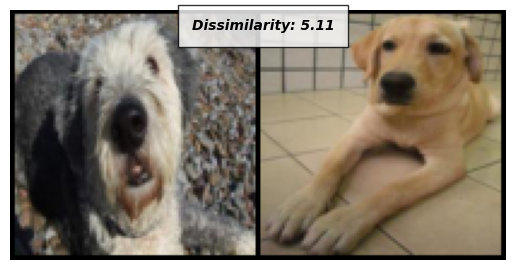

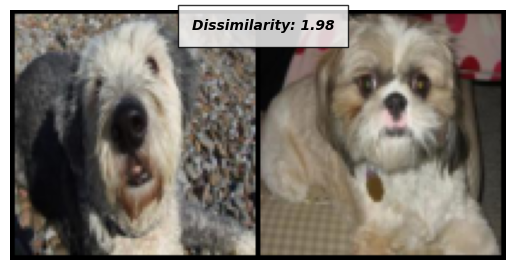

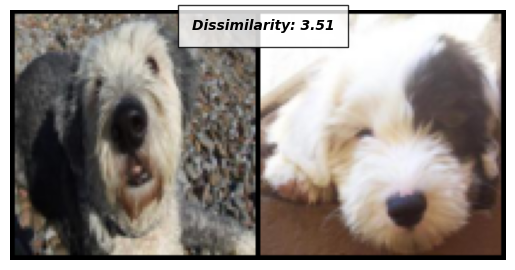

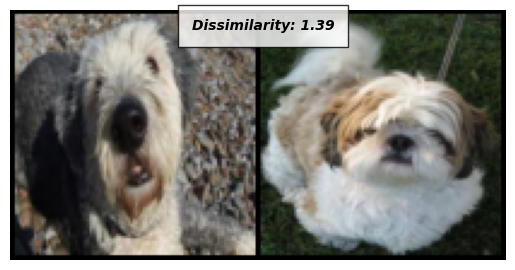

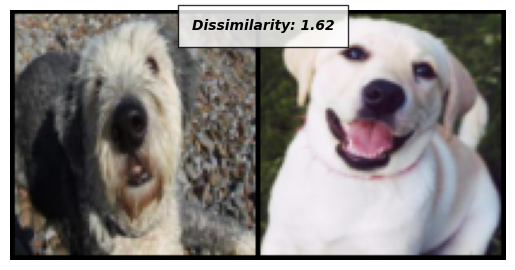

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/subset/test/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)
print(x0.size())

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

## Archived

In [ ]:
class SiameseNetworkTestDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        path, breed = self.imageFolderDataset.imgs[index]

        image = Image.open(path)
        image = image.convert("RGB")

        if self.transform is not None:
            image = self.transform(image)
        
        return image, breed

    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/subset/test/")
folder_dataset_train = datasets.ImageFolder(root="./data/subset/train/")

transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

siamese_test_dataset = SiameseNetworkTestDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
siamese_train_dataset = SiameseNetworkTestDataset(imageFolderDataset=folder_dataset_train ,
                                        transform=transformation)

test_dataloader = DataLoader(siamese_test_dataset, num_workers=2, batch_size=1, shuffle=True)
train_dataloader = DataLoader(siamese_train_dataset, num_workers=2, batch_size=1, shuffle=True)


In [ ]:
dog, breed = next(iter(test_dataloader))
output1, output2 = net(dog.cuda(), dog.cuda())
F.pairwise_distance(output1, output2)

tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>)

In [ ]:

correct_prediction = 0
for i, (dog1, breed1) in enumerate(train_dataloader):
    
    best_distance = np.inf
    best_prediction = 0
    # calculate the similarity between all dogs in the test set and obtain the most similar breed
    for j, (dog2, breed2) in enumerate(train_dataloader):
        if i==j:
            continue
        output1, output2 = net(dog1.cuda(), dog2.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        if euclidean_distance <= best_distance:
            best_distance = euclidean_distance
            best_prediction = breed2
    
    if best_prediction == breed1:
        correct_prediction += 1
    
print("The training accuracy is ", correct_prediction/len(train_dataloader))

    

The training accuracy is  1.0


In [ ]:
correct_prediction = 0
for i, (dog1, breed1) in enumerate(test_dataloader):
    
    best_distance = np.inf
    best_prediction = 0
    # calculate the similarity between all dogs in the test set and obtain the most similar breed
    for j, (dog2, breed2) in enumerate(train_dataloader):
        if i==j:
            continue
        output1, output2 = net(dog1.cuda(), dog2.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        if euclidean_distance <= best_distance:
            best_distance = euclidean_distance
            best_prediction = breed2
    
    if best_prediction == breed1:
        correct_prediction += 1
    
print("The test accuracy is ", correct_prediction/len(test_dataloader))

The test accuracy is  0.38591549295774646


In [ ]:
len(folder_dataset_test.imgs)

355

# ChatGPT codes, collapsed

In [ ]:
def load_data(folder_path, device):
    labels = {}
    idx = 0
    images = []
    labels_r = {}
    for folder in os.listdir(folder_path):
        idx += 1
        labels[folder] = idx
        labels_r[idx] = folder
    for folder in os.listdir(folder_path):
        for file in os.listdir(os.path.join(folder_path, folder)):
            img_path = os.path.join(folder_path, folder, file)
            img = Image.open(img_path).convert("RGB")
            img = np.array(img)
            images.append([img, np.eye(labels[folder] + 1, len(labels))[labels[folder]]])
    np.random.shuffle(images)
    X = []
    y = []
    for d in images:
        X.append(d[0])
        y.append(d[1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    X_train = torch.from_numpy(np.array(X_train)).to(device).permute(0, 3, 1, 2)
    y_train = torch.from_numpy(np.array(y_train)).to(device).float()
    X_test = torch.from_numpy(np.array(X_test)).to(device).permute(0, 3, 1, 2)
    y_test = torch.from_numpy(np.array(y_test)).to(device).float()
    return X, y, X_train, X_test, y_train, y_test, labels, labels_r, idx, images

X, y, X_train, X_test, y_train, y_test, labels, labels_r, idx, data = load_data(folder_path, device)
print("Train input size:", X_train.size())

In [ ]:
folder_path = '/content/drive/MyDrive/CS_679_Project/cropped/train'

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx % len(self.images)]
        label = self.labels[idx % len(self.labels)]
        image = Image.fromarray(image.transpose(1, 2, 0).astype(np.uint8), mode='RGB')

        if self.transform:
            image = self.transform(image)

        # Convert the image to a tensor
        image = self.to_tensor(image)

        return image, torch.tensor(label, dtype=torch.float32)

data_augmentation_transforms = Compose([
    # RandomResizedCrop(224, scale=(0.8, 1.0)),
    # RandomHorizontalFlip(),
    RandomRotation(30)
    # ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
])

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx % len(self.images)]
        label = self.labels[idx % len(self.labels)]
        image = Image.fromarray(image.transpose(1, 2, 0).astype(np.uint8), mode='RGB')

        if self.transform:
            image = self.transform(image)

        # Convert the image to a tensor
        image = self.to_tensor(image)

        return image, torch.tensor(label, dtype=torch.float32)

data_augmentation_transforms = Compose([
    # RandomResizedCrop(224, scale=(0.8, 1.0)),
    # RandomHorizontalFlip(),
    RandomRotation(30)
    # ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
])

In [ ]:
batch_size = 8

# Create an instance of the CustomImageDataset for the original images
original_dataset = CustomImageDataset(X_train.cpu().numpy(), y_train.cpu().numpy())

# Create an instance of the CustomImageDataset with the data augmentation transforms
augmented_dataset = CustomImageDataset(X_train.cpu().numpy(), y_train.cpu().numpy(), transform=data_augmentation_transforms)


# Concatenate the original and augmented datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Create a DataLoader with the desired batch size for the augmented dataset
combined_data_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
pip install opencv-python opencv-python-headless opencv-contrib-python scikit-image

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage import feature

In [ ]:
class ImagePairsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img1 = self.images[idx]
        label1 = self.labels[idx]

        idx2 = np.random.choice(len(self.images))
        img2 = self.images[idx2]
        label2 = self.labels[idx2]

        return (img1, img2), (label1, label2)

In [ ]:
def extract_sift_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray_image, None)
    return des

def extract_lbp_features(image, num_points, radius, method="uniform"):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = feature.local_binary_pattern(gray_image, num_points, radius, method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

In [ ]:
class ImagePairsFeatureDataset(Dataset):
    def __init__(self, images, targets, num_lbp_points, lbp_radius):
        self.images = images
        self.targets = targets
        self.num_lbp_points = num_lbp_points
        self.lbp_radius = lbp_radius

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img1 = self.images[idx].astype('uint8')
        img2 = self.images[(idx + 1) % len(self.images)].astype('uint8')

        # Ensure that the images have 3 channels
        if img1.shape[2] != 3:
            img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
        if img2.shape[2] != 3:
            img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

        img1_sift = extract_sift_features(img1)
        img2_sift = extract_sift_features(img2)
        img1_lbp = extract_lbp_features(img1, self.num_lbp_points, self.lbp_radius)
        img2_lbp = extract_lbp_features(img2, self.num_lbp_points, self.lbp_radius)

        img1_features = np.concatenate((img1_sift, img1_lbp))
        img2_features = np.concatenate((img2_sift, img2_lbp))

        label1 = self.targets[idx]
        label2 = self.targets[(idx + 1) % len(self.targets)]

        return (torch.tensor(img1_features).float(), torch.tensor(img2_features).float()), (label1, label2)

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x1, x2):
        output1 = self.fc(x1)
        output2 = self.fc(x2)
        return output1, output2

In [ ]:
def train_siamese_network(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        i = 0
        for (inputs1, inputs2), targets in dataloader:
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs1, outputs2 = model(inputs1, inputs2)
            loss = criterion(outputs1, targets) + criterion(outputs2, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            i += 1
            print(f"Epoch {epoch + 1}, Loss: {running_loss / i}")

    print("Finished Training")

In [ ]:
def evaluate_siamese_network(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for (inputs1, inputs2), targets in dataloader:
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
            targets = targets.to(device)

            outputs1, outputs2 = model(inputs1, inputs2)
            predicted1 = torch.argmax(outputs1, dim=1)
            predicted2 = torch.argmax(outputs2, dim=1)

            correct += (predicted1 == targets).sum().item() + (predicted2 == targets).sum().item()
            total += 2 * targets.size(0)

    print(f"Accuracy: {100 * correct / total}%")

In [ ]:
# num_lbp_points = 24
# lbp_radius = 8
# feature_dim = 128 + num_lbp_points  # SIFT + LBP feature dimensions
# num_classes = 120

# train_dataset = ImagePairsFeatureDataset(X_train.cpu().numpy(), y_train.cpu().numpy(), num_lbp_points, lbp_radius)
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# test_dataset = ImagePairsFeatureDataset(X_test.cpu().numpy(), y_test.cpu().numpy(), num_lbp_points, lbp_radius)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)




num_lbp_points = 24
lbp_radius = 3

train_pairs_dataset = ImagePairsFeatureDataset(X_train.cpu().numpy(), y_train.cpu().numpy(), num_lbp_points, lbp_radius)
test_pairs_dataset = ImagePairsFeatureDataset(X_test.cpu().numpy(), y_test.cpu().numpy(), num_lbp_points, lbp_radius)

batch_size = 32
train_pairs_loader = DataLoader(train_pairs_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_pairs_loader = DataLoader(test_pairs_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

feature_dim = 128 + num_lbp_points * 2  # 128 for SIFT, num_lbp_points * 2 for LBP

siamese_net = SiameseNetwork(feature_dim, num_classes = 120).to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork(feature_dim, num_classes = 120).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
num_epochs = 10
running_loss_history = []

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, ((img1_features, img2_features), (label1, label2)) in enumerate(train_pairs_loader):
        img1_features = img1_features.to(device)
        img2_features = img2_features.to(device)
        label1 = label1.to(device)
        label2 = label2.to(device)

        optimizer.zero_grad()

        output1, output2 = siamese_net(img1_features, img2_features)
        loss = criterion(output1, output2, label1, label2)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / (i + 1)
    running_loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

print("Finished Training")